In [2]:
#we import the libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import LogLocator
from scipy import linalg
from matplotlib.animation import FuncAnimation
import pandas as pd

In [2]:
#we see the structure of the data in the file particle.dat
data = np.loadtxt('particles.dat')   
print("Shape of data:", data.shape)

df = pd.DataFrame(data, columns=["x", "y"])

print(df)

Shape of data: (24478, 2)
               x          y
0      51.526619  53.322742
1      50.394722  46.322815
2      48.705956  45.986626
3      87.786476  40.758865
4      46.489464  11.477116
...          ...        ...
24473  39.599144  68.452606
24474  56.581814  29.868458
24475  66.786804  62.917507
24476  41.081547  69.211014
24477  58.269341  69.498154

[24478 rows x 2 columns]


In [3]:
M = 100 #size of the box 
N = 100 #number of cells per size 

Deltax = M/N
Deltay = M/N

xp = data[:, 0]
yp = data[:, 1]

#now we create the grid

X_grid = np.linspace(0, M, N)
Y_grid = np.linspace(0, M, N)
X, Y = np.meshgrid(X_grid, Y_grid) #this create the grid
rho = np.zeros((N, N)) #we create the density array initialized to zero 

#now we assign the particle at the grid using the triangular assignment function
def S(x, Deltax):
    x = np.abs(x)
    return np.where(x < Deltax, (1 - x/Deltax)/Deltax, 0) #x is the distance of the particle from the corner of each small cell 

#we loop over all the particles
for x_p,y_p in zip(xp,yp):
    
    #now we find in whihc cell the particle is located
    index_xp = int(x_p/Deltax)
    index_yp = int(y_p/Deltax)

    #then we can compute the position respect the corner

    for di in [0,1]:
        for dj in [0,1]:
            ii = index_xp + di #position x of the four corners
            jj = index_yp + dj #position y of the four corners

            if ii < N and jj < N:
                dx_rel = x_p - (ii + 0.5) * Deltax
                dy_rel = y_p - (jj + 0.5) * Deltay
                
                rho[ii, jj] += S(dx_rel, Deltax) * S(dy_rel, Deltay)


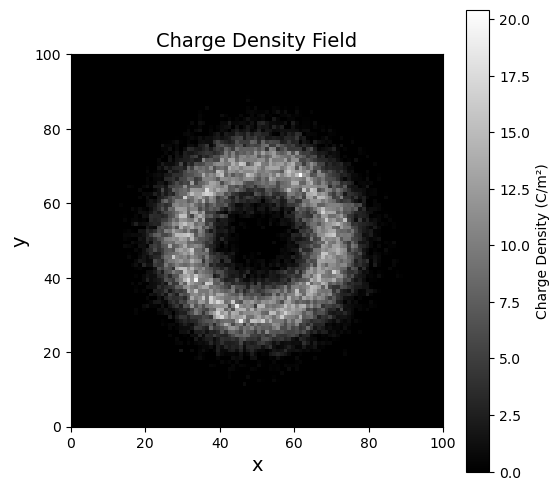

In [4]:
# Plot the charge density field
plt.figure(figsize=(6,6))
plt.imshow(rho.T, origin='lower', extent=[0, M, 0, M], cmap='gray')
plt.colorbar(label="Charge Density (C/m²)")
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.title("Charge Density Field", fontsize = 14)
plt.show()

In [5]:
#let's define the funxtion that solve the partial differential equation 

def relaxation(delta, target, M, phiprime, phi, eps0, a, rho):
    N = 0 #number of iteration
    while delta>target:
        N = N + 1

        # Calculate new values of the potential
        for i in range(M+1):
            for j in range(M+1):
                if i==0 or i==M or j==0 or j==M:
                    phiprime[i,j] = phi[i,j]
                else:
                    phiprime[i,j] = (phi[i+a,j] + phi[i-a,j] \
                                    + phi[i,j+a] + phi[i,j-a])/4 + (a**2/eps0)*rho[i, j]

        # Calculate maximum difference from old values
        delta = max(abs(phi-phiprime))

        # Swap the two arrays around
        phi,phiprime = phiprime,phi
    return phi, N


Number of Iteration: 50338


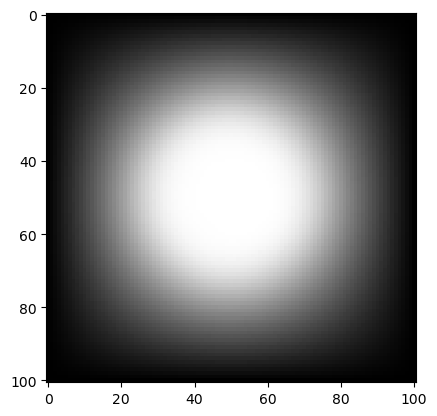

In [6]:
#we now solve the Poisson equation in the grid 
from numpy import empty,zeros,max
import matplotlib.pyplot as plt

# Constants
M = 100         # Grid squares on a side
V = 0.0         # Voltage at top wall
target = 1e-10   # Target accuracy
a = 1
eps0 = 1

# Create arrays to hold potential values
phi = zeros([M+1,M+1],float)

phi[0, :] = 0
phi[M, :] = 0
phi[:, 0] = 0
phi[:, M] = 0

phiprime = empty([M+1,M+1],float)

# Main loop
delta = 1.0

phi, N = relaxation(delta, target, M, phiprime, phi, eps0, a, rho)

print(f"Number of Iteration: {N}")
# Make a plot
plt.imshow(phi)
plt.gray()
plt.show()

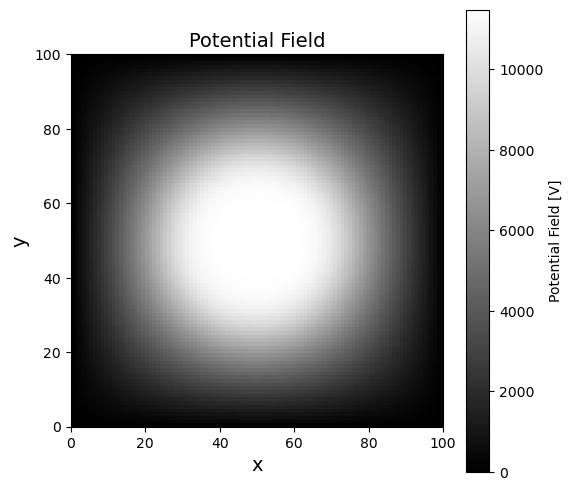

In [7]:
# Plot the charge density field
plt.figure(figsize=(6,6))
plt.imshow(phi, origin='lower', extent=[0, M, 0, M], cmap='gray')
plt.colorbar(label="Potential Field [V]")
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.title("Potential Field", fontsize = 14)
plt.show()

In [8]:
#let's define the funxtion that solve the partial differential equation 

def Gauss_Seidel(delta, target, M, phi, eps0, a, omega, rho):
    N = 0

    while delta > target:
        N += 1
        max_diff = 0.0

        for i in range(1, M):
            for j in range(1, M):

                GS =1/4 * (
                    phi[i+1,j] + phi[i-1,j] +
                    phi[i,j+1] + phi[i,j-1] +
                    (a**2/eps0)*rho[i,j]
                )

                new_val = (1 + omega)*GS - omega * phi[i,j]

        
                diff = abs(new_val - phi[i,j])
                if diff > max_diff:
                    max_diff = diff

                phi[i,j] = new_val
        
        delta = max_diff

    return phi, N



Number of Iteration: 601


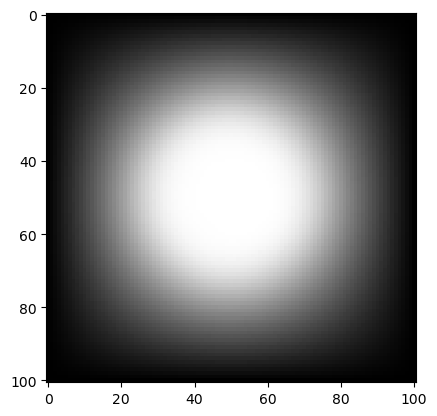

In [9]:
#we know implement the Guass-Seidel overrelaxation method in order to understand if it works

#we now solve the Poisson equation in the grid 
from numpy import empty,zeros,max
import matplotlib.pyplot as plt

# Constants
M = 100         # Grid squares on a side
V = 0.0         # Voltage at top wall
target = 1e-10   # Target accuracy
a = 1

precision_omega = 0.001

eps0 = 1

phi[0, :] = 0
phi[M, :] = 0
phi[:, 0] = 0
phi[:, M] = 0

# Create arrays to hold potential values
phi = zeros([M+1,M+1],float)

# Main loop
delta = 1.0
omega = 0.95 #parameter of the overelaxtion method

phi, N = Gauss_Seidel(delta, target, M , phi, eps0, a, omega, rho)
print(f"Number of Iteration: {N}")

# Make a plot
plt.imshow(phi)
plt.gray()
plt.show()

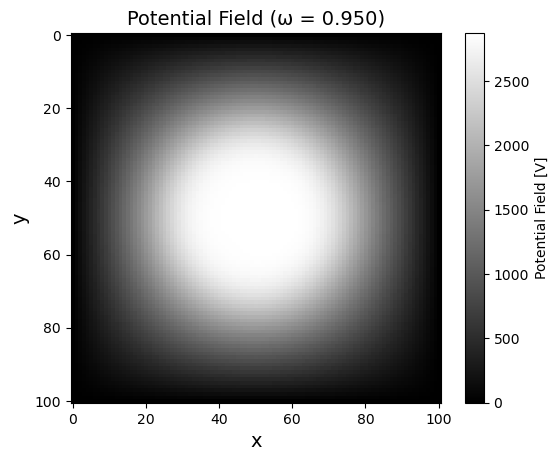

In [10]:
# -------------------------
#   Plot potential
# -------------------------
plt.imshow(phi, cmap="gray")
plt.colorbar(label="Potential Field [V]")
plt.title(f"Potential Field (ω = {omega:.3f})", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.show()

In [11]:
import numpy as np
import matplotlib.pyplot as plt


# ---------------------------------------------------------
#   GOLDEN SECTION SEARCH FOR OPTIMAL ω
# ---------------------------------------------------------
def solve_with_omega(omega):
    phi = np.zeros((M+1, M+1), float)
    delta = 1.0
    _, iters = Gauss_Seidel(delta, target, M , phi, eps0, a, omega, rho)
    return iters


def golden_section_search(a0, b0, tol):
    gr = (np.sqrt(5) - 1) / 2  # golden ratio constant

    a = a0
    b = b0

    c = b - gr*(b - a)
    d = a + gr*(b - a)

    f_c = solve_with_omega(c)
    f_d = solve_with_omega(d)

    omega_points = []
    iter_points  = []

    while abs(b - a) > tol:
        omega_points.append(c)
        iter_points.append(f_c)
        omega_points.append(d)
        iter_points.append(f_d)

        if f_c < f_d:
            b = d
            d = c
            f_d = f_c
            c = b - gr*(b - a)
            f_c = solve_with_omega(c)
        else:
            a = c
            c = d
            f_c = f_d
            d = a + gr*(b - a)
            f_d = solve_with_omega(d)

    best_omega = (a + b) / 2
    return best_omega, omega_points, iter_points

In [20]:

# -------------------------
#   MAIN CODE
# -------------------------

M = 100
target = 1e-10
eps0 = 1

# -------- GOLDEN SECTION SEARCH --------
omega_min = 0.1
omega_max = 0.99
precision = 0.001

best_omega, omega_pts, iter_pts = golden_section_search(omega_min, omega_max, precision)

print("\nOptimal ω found =", best_omega)


Optimal ω found = 0.9404790161701633


In [21]:
# -------------------------
# Final solution with best ω
# -------------------------
phi = np.zeros((M+1, M+1))
phiprime = np.zeros((M+1, M+1))
delta = 1.0

phi, N_final = Gauss_Seidel(delta, target, M , phi, eps0, a, omega, rho)
print("Iterations at optimal ω: ", N_final)

Iterations at optimal ω:  601


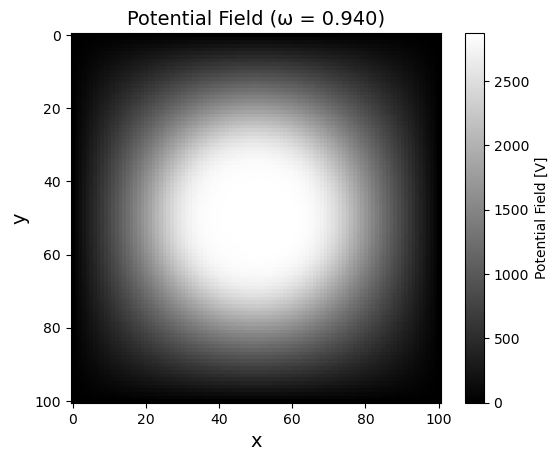

In [22]:
# -------------------------
#   Plot potential
# -------------------------
plt.imshow(phi, cmap="gray")
plt.colorbar(label="Potential Field [V]")
plt.title(f"Potential Field (ω = {best_omega:.3f})", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.show()

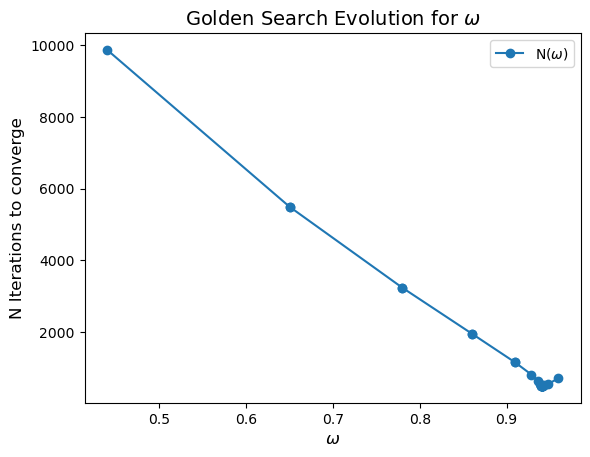

In [ ]:
# -------------------------
#   Plot evolution of ω
# -------------------------
# Ordino i punti in base a omega
omega_sorted, iter_sorted = zip(*sorted(zip(omega_pts, iter_pts)))

plt.plot(omega_sorted, iter_sorted, "o-", label="N($\omega$)")
plt.xlabel(r"$\omega$", fontsize=12)
plt.ylabel("N Iterations to converge", fontsize=12)
plt.title("Golden Search Evolution for $\omega$", fontsize=14)
plt.legend()
plt.show()